In [15]:
import os
import random
import seaborn as sns
import csv
import numpy as np
import copy
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pandas as pd
from scipy import stats
import math
import scipy.special
%matplotlib inline

file_path="C:/Users/Zeta/Documents/acou_sommeil_HD_ENS/tinnitus-nocturnal-stimulation"

In [2]:
df_matin={}
os.chdir(file_path+"/df_matin")
files = os.listdir(file_path+"/df_matin")
for file in files:
    df_matin[file.split("_")[0]]=pd.read_csv(file, sep=";")
print("exemple matin")
print(df_matin["1ZN04"])

print("")

df_soir={}
os.chdir(file_path+"/df_soir")
files = os.listdir(file_path+"/df_soir")
for file in files:
    df_soir[file.split("_")[0]]=pd.read_csv(file, sep=";")
print("exemple soir")
print(df_soir["1ZN04"])

exemple matin
   Patient ID  relative date  masking volume  VAS-L  VAS-I  \
0       1ZN04            -22        7.333333    2.0    1.0   
1       1ZN04            -21        5.000000    3.0    2.0   
2       1ZN04            -21        5.000000    3.0    2.0   
3       1ZN04            -20        5.666667    NaN    NaN   
4       1ZN04            -19        5.000000    4.0    3.0   
5       1ZN04            -18        4.666667    5.0    3.0   
6       1ZN04            -17        4.666667    3.0    2.0   
7       1ZN04            -16        4.666667    2.0    2.0   
8       1ZN04            -15        5.333333    3.0    3.0   
9       1ZN04             -3        4.000000    4.0    2.0   
10      1ZN04             -1        5.333333    3.0    2.0   
11      1ZN04              0        4.666667    3.0    2.0   
12      1ZN04              2        4.666667    3.0    1.0   
13      1ZN04              3        5.333333    3.0    2.0   
14      1ZN04              4        4.333333    3.0    2

In [50]:
def test_randomisé_inferiorité(li_obs, val_test, itera):

    obs_stat= np.sum(li_obs)
    compt=0
    for i in range(itera):
        to_exclude = int(random.random()*len(li_obs))
        li_obs2=copy.deepcopy(li_obs)
        li_obs2.pop(to_exclude)
        li_obs2.append(val_test)

        if np.sum(li_obs2)> obs_stat:
            compt+=1

    pval = float(compt/itera)
    return (pval)

def combine_p_values(vect_p):
    sump=0.0
    N = len(vect_p)
    for k in range(N):
        sump+=vect_p[k]
    #print sump
    lnfact=0.0
    for k in range(N-1):
        #print k
        lnfact+= math.log(k+2)
    #print lnfact
    k=0
    num=0
    sw=1.0
    while (sump-k)>0 :
        num+= (scipy.special.binom(N, k)*((sump-k)**N))*sw
        k=k+1
        sw= - sw
        #print sw
    #print num
    if num == 0 : 
        return 0
    else:
        res = math.exp(math.log(num)-lnfact)
    return res


def get_me_p_vals(df, column):
    p_vals_par_patient={}
    p_vals_par_jour=[[] for i in range(15)]

    for elm in df:
        
        p_vals_par_patient[elm]=[]
        distrib_pre_intervention=[]
        for index, row in df[elm].iterrows():
            if row['relative date'] < -1:
                if not np.isnan(row[column]):
                    distrib_pre_intervention.append(row[column])
            if row['relative date'] >= 0:
                break
        for index, row in df[elm].iterrows():
            if len(distrib_pre_intervention)>3: #Au moins 4 scores dans la distribution pre-intervention
                if row['relative date'] >= 0:
                    if not np.isnan(row[column]):
                        post_intervention = row[column]
                        p_val= test_randomisé_inferiorité(distrib_pre_intervention, post_intervention, 10000)
                        p_vals_par_patient[elm].append(p_val)
                        p_vals_par_jour[row['relative date']].append(p_val)
    print("computing done")
    return(p_vals_par_patient, p_vals_par_jour)
    

def affichage_results_group(p_vals_par_jour):
    compt=0
    li_comb=[]
    for li in p_vals_par_jour:
        if len(li)>7:  #we only combine p_vals if there are more than 7 patients included
            print("Combined p_value for day "+ str(compt))
            comb= combine_p_values(li)
            print(comb)
            li_comb.append(comb)
        compt+=1

    print("affichage sequence combined p_values :")
    l=[0.05 for i in range(len(li_comb))]
    plt.figure()
    plt.plot(li_comb)
    plt.plot(l)
    plt.title("Group combined p_values sequence for post intervention days, orange line: 0.05 threshold")
    plt.xlabel("days after intervention")
    plt.ylabel("combined p_value")
    
def affichage_results_intra(p_vals_par_patient):
    for elm in p_vals_par_patient:
        l=[0.05 for i in range(len(p_vals_par_patient[elm]))]
        plt.figure()
        plt.plot(p_vals_par_patient[elm])
        plt.plot(l)
        plt.title(elm + " p_values sequence for post intervention days, orange line: 0.05 threshold")
        plt.xlabel("days after intervention")
        plt.ylabel("p_value")

# Computing all metrics

In [44]:
p_vals_par_patient_matin_mask, p_vals_par_jour_matin_mask = get_me_p_vals(df_matin, "masking volume")

p_vals_par_patient_soir_mask, p_vals_par_jour_soir_mask = get_me_p_vals(df_soir, "masking volume")

p_vals_par_patient_matin_VAS_L, p_vals_par_jour_matin_VAS_L = get_me_p_vals(df_matin, "VAS-L")

p_vals_par_patient_matin_VAS_I, p_vals_par_jour_matin_VAS_I = get_me_p_vals(df_matin, "VAS-I")

computing done
computing done
computing done
computing done


# Analyse intra-sujet matin masquage

Combined p_value for day 0
0.00032710875065854227
Combined p_value for day 1
0.01863573706825962
Combined p_value for day 2
0.1124368020969087
Combined p_value for day 3
0.7257804796668816
Combined p_value for day 4
0.07184578003322453
Combined p_value for day 5
0.5019315170795132
Combined p_value for day 6
0.2551571479332379
affichage sequence combined p_values :


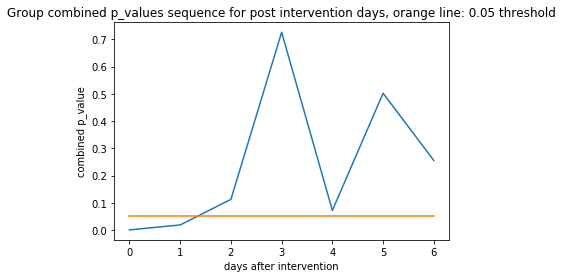

In [51]:
affichage_results_group(p_vals_par_jour_matin_mask)

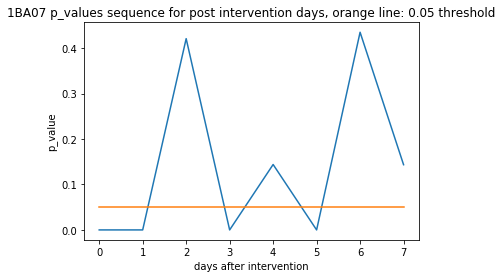

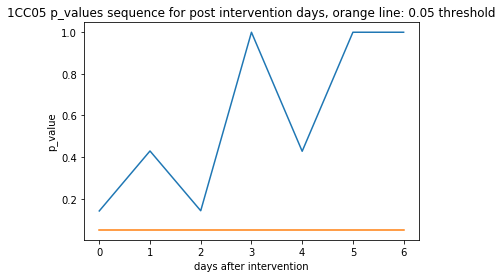

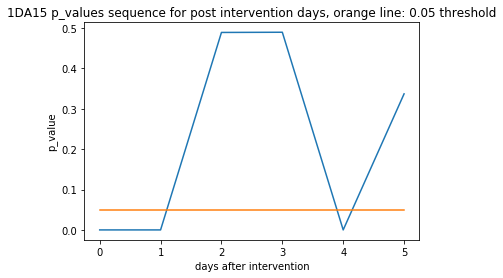

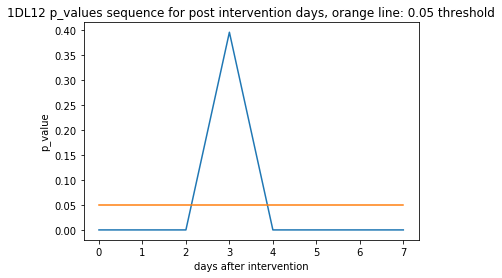

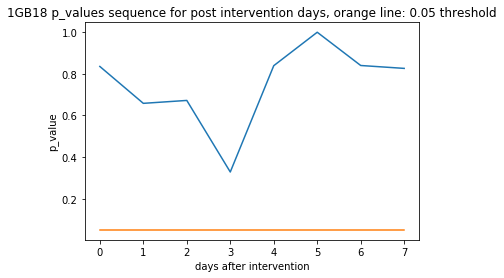

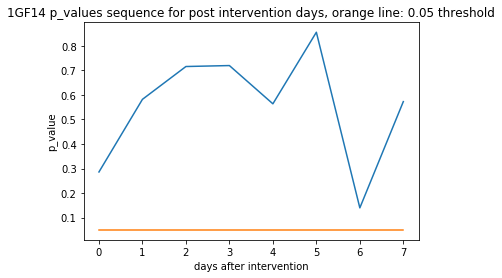

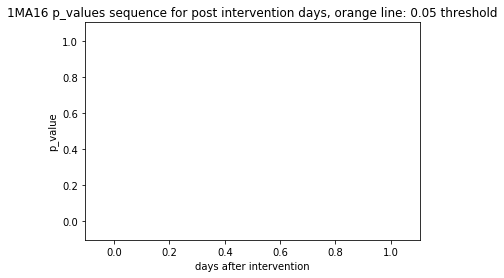

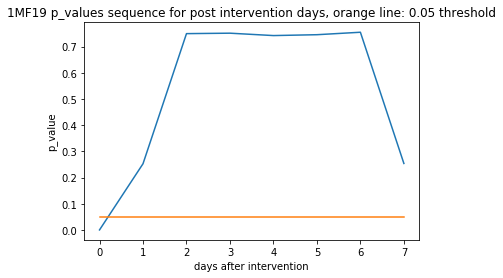

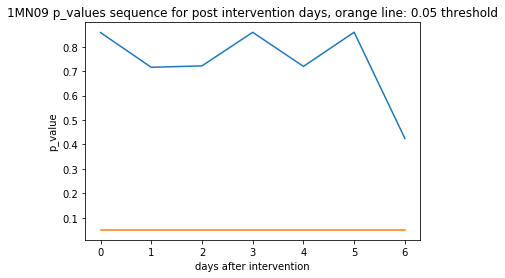

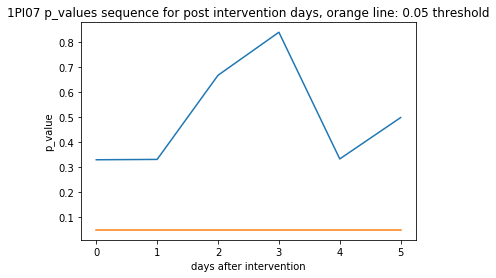

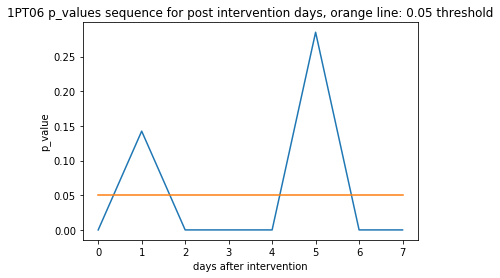

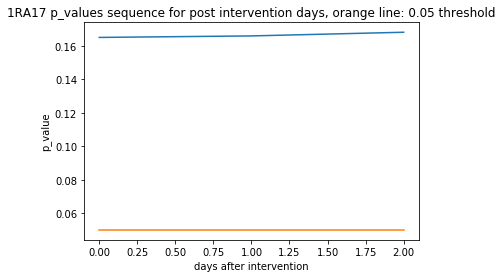

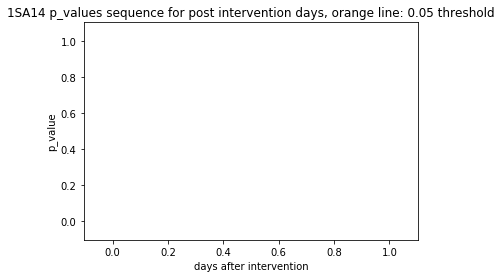

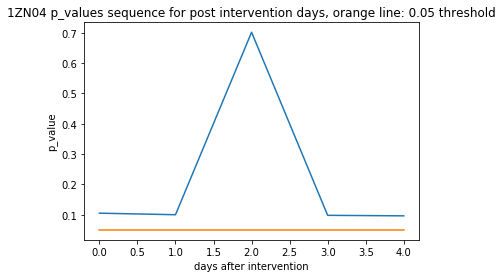

In [52]:
affichage_results_intra(p_vals_par_patient_matin_mask)

# Analyse intra-sujet soir masquage

Combined p_value for day 0
0.027055744029780646
Combined p_value for day 1
0.6444770943956211
Combined p_value for day 2
0.39385644265242353
Combined p_value for day 3
0.39298406706963984
Combined p_value for day 4
0.2864207248433977
Combined p_value for day 5
0.4227021052398626
Combined p_value for day 6
0.25672601921843674
affichage sequence combined p_values :


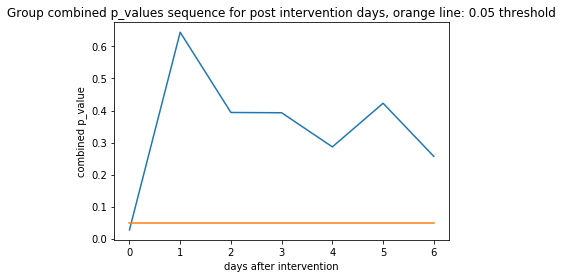

In [53]:
affichage_results_group(p_vals_par_jour_soir_mask)

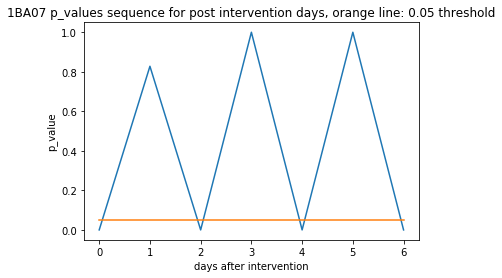

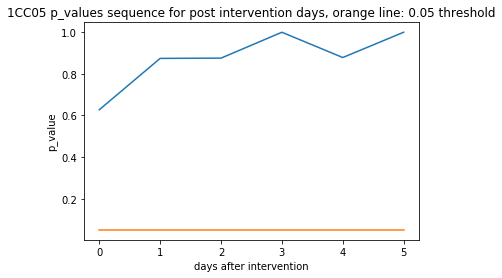

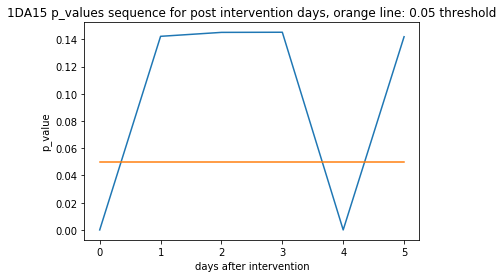

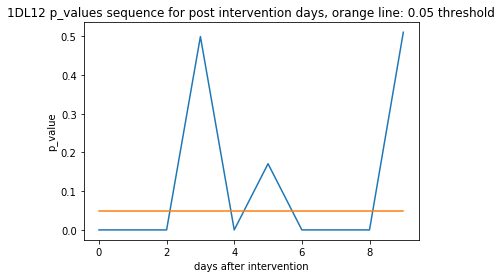

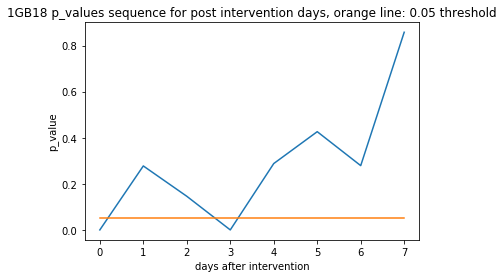

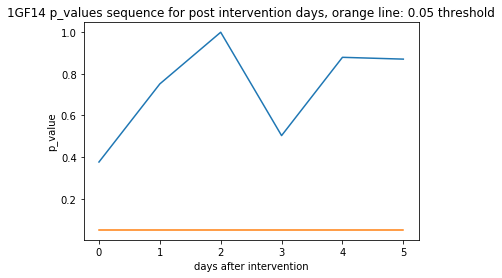

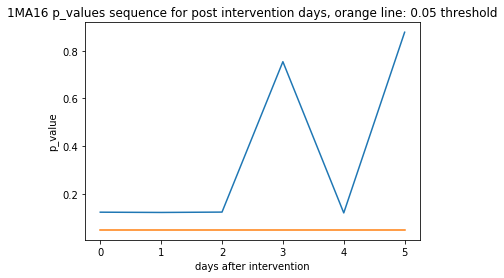

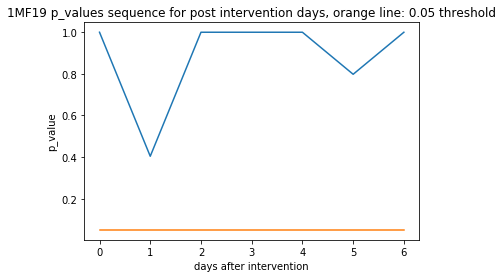

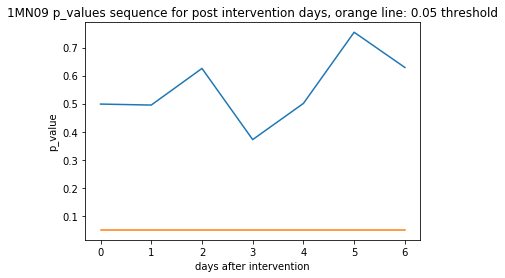

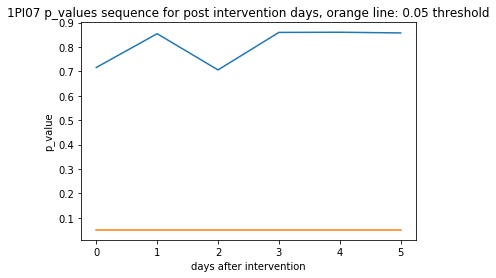

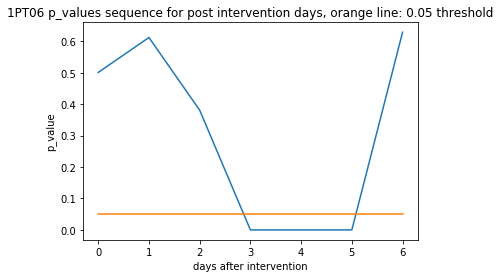

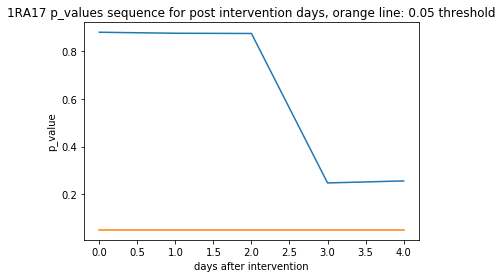

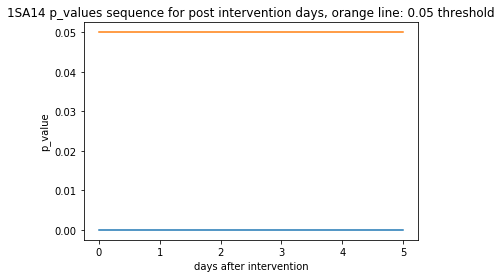

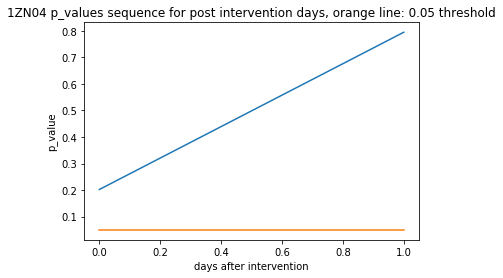

In [54]:
affichage_results_intra(p_vals_par_patient_soir_mask)

# Analyse intra-sujet matin VAS-L

Combined p_value for day 0
7.082220432353178e-07
Combined p_value for day 1
0.002752758021001148
Combined p_value for day 3
0.11688433842708615
Combined p_value for day 4
0.05138610297104377
Combined p_value for day 5
0.23026334637413773
Combined p_value for day 6
0.15146169488512043
affichage sequence combined p_values :


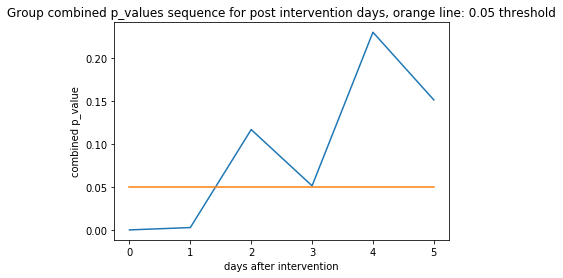

In [56]:
affichage_results_group(p_vals_par_jour_matin_VAS_L)

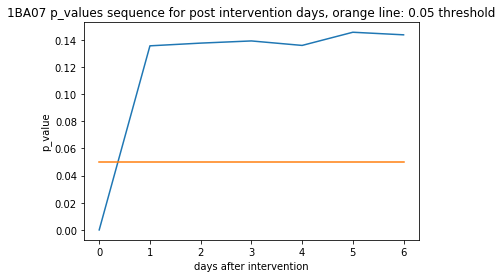

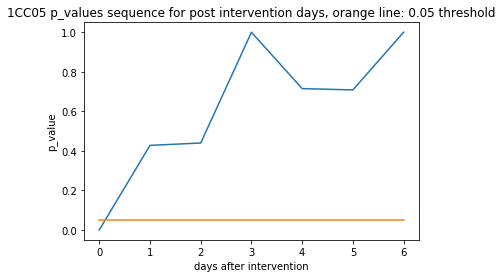

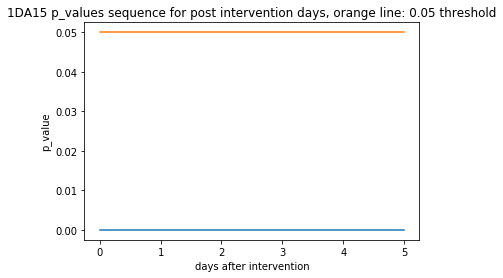

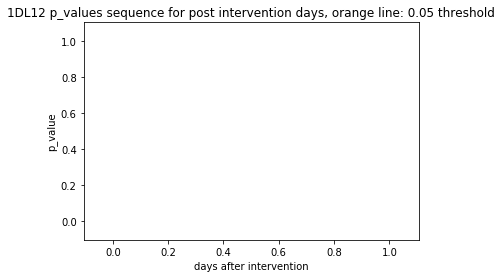

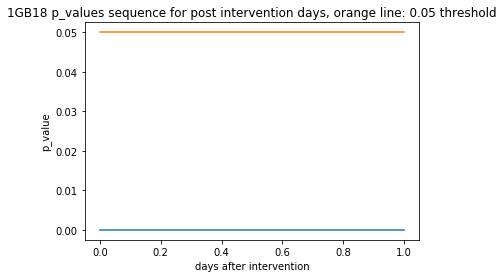

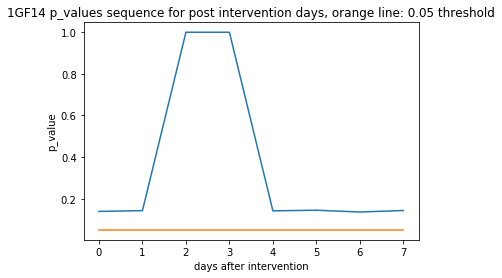

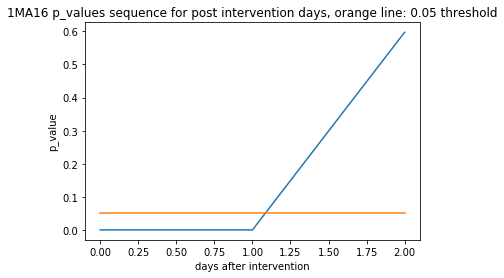

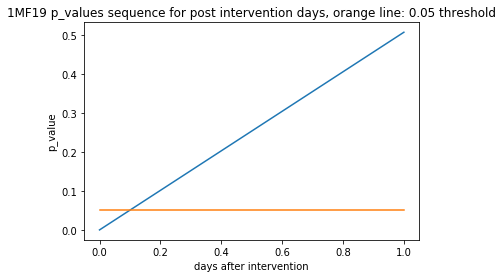

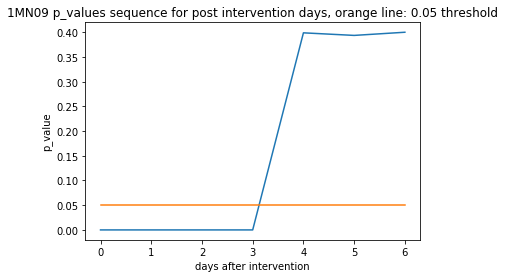

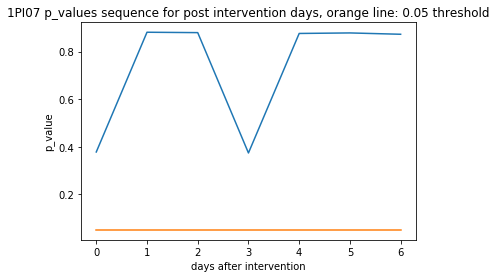

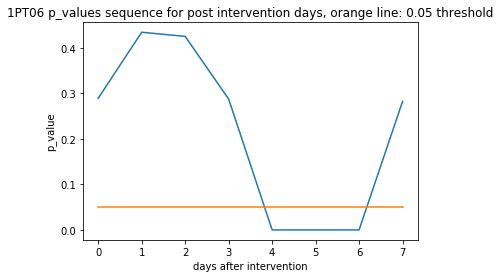

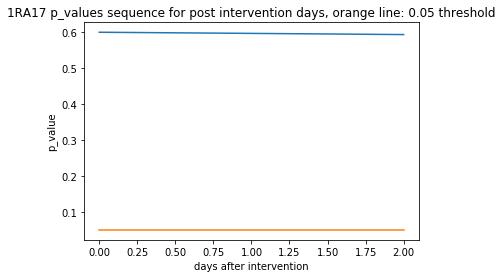

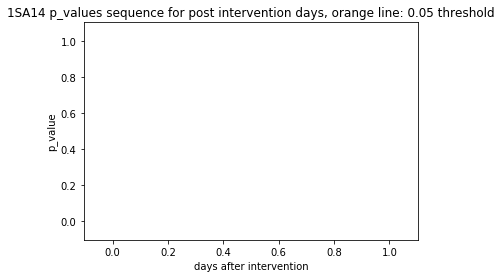

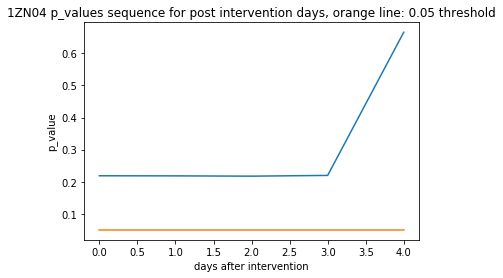

In [57]:
affichage_results_intra(p_vals_par_patient_matin_VAS_L)

# Analyse intra-sujet matin VAS_I

Combined p_value for day 0
0.002836508525558116
Combined p_value for day 1
0.011793290307035591
Combined p_value for day 3
0.020328550520483046
Combined p_value for day 4
0.004452795183365152
Combined p_value for day 5
0.45117483842929795
Combined p_value for day 6
0.12270021335863704
affichage sequence combined p_values :


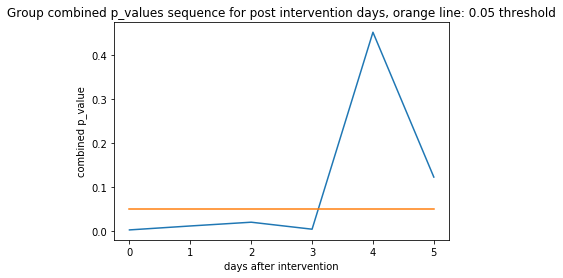

In [58]:
affichage_results_group(p_vals_par_jour_matin_VAS_I)

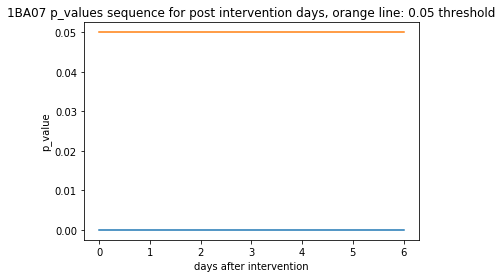

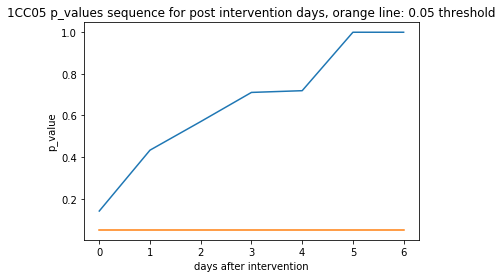

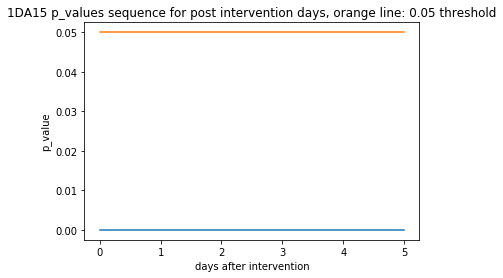

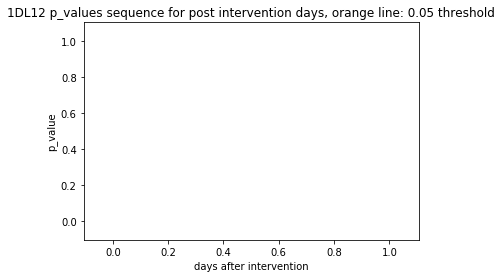

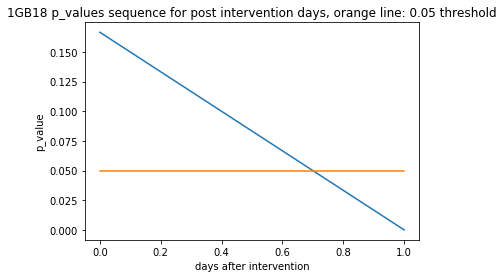

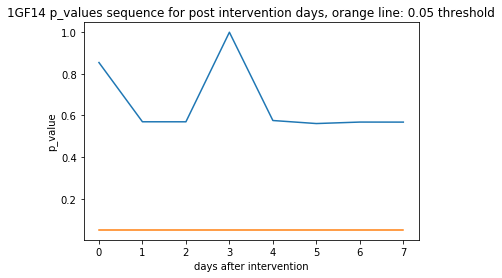

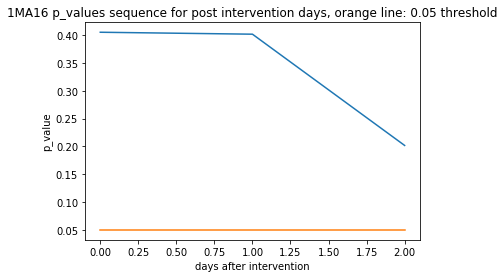

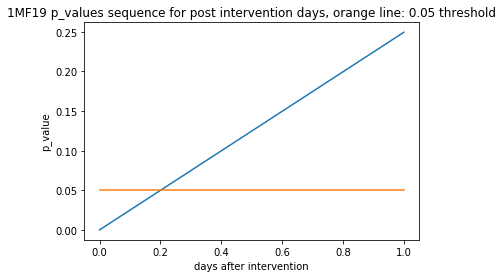

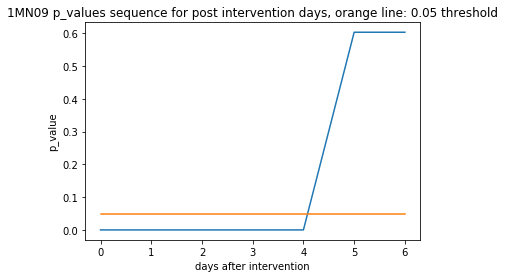

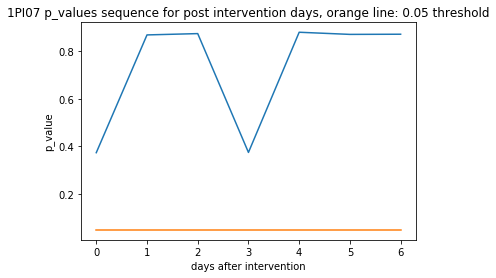

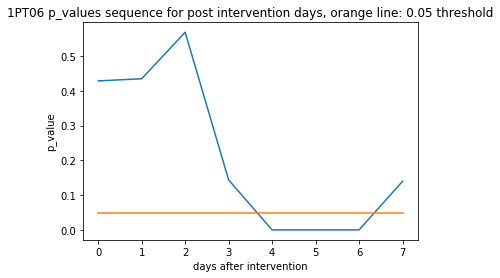

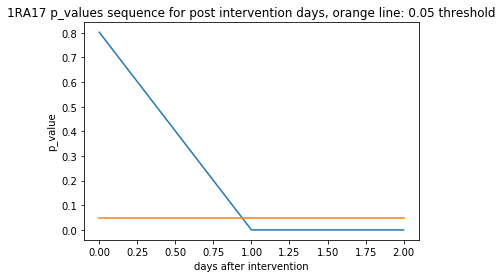

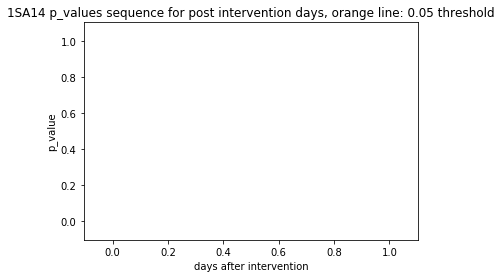

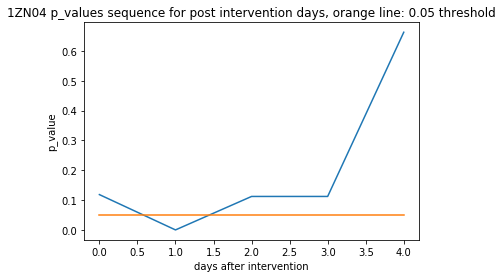

In [59]:
affichage_results_intra(p_vals_par_patient_matin_VAS_I)